*Page and Latex Commands*
$\newcommand{\C}{\mathbb{C}}
\renewcommand{\R}{\mathbb{R}}
\renewcommand{\Z}{\mathbb{Z}}
\renewcommand{\N}{\mathbb{N}}
\newcommand{\Q}{\mathbb{Q}}
\newcommand{\mP}{\mathcal{P}}
\newcommand{\bp}{\begin{pmatrix}}
\newcommand{\ep}{\end{pmatrix}}
$

In [55]:
from jupyterthemes import jtplot
jtplot.style()

# Hide Warnings
import warnings
warnings.filterwarnings('ignore')

# Import Packages
import cvxpy as cp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import sys

sys.path.append('..\lib')

from findiff import *

# Poisson Problem

**Problem Statement**

Solve the following equation subject to various values of $\lambda$, $f$ and boundary conditions.

$$-\nabla \cdot (\lambda \nabla u) = f$$


# Constant Coefficient Problem

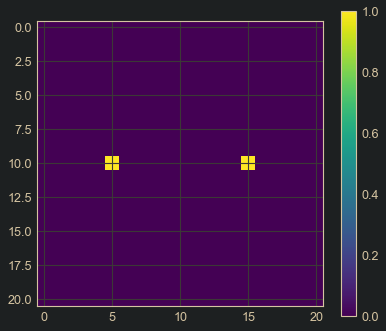

In [56]:
n = m = 21
h=1/(n-1)
xx,yy = np.meshgrid(np.linspace(0,1,n),np.linspace(0,1,m))

BC = "Mixed"

# Distributions
rho = np.zeros((n,m))
rho[n//2,n//4] = 1
sigma = np.zeros((n,m))
sigma[n // 2,3*n // 4] = 1

f = sigma.flatten()-rho.flatten()

#Gradient C
Gc = np.ones(n*n)

# FDM
P = DD2P5(n,m,bc=BC,matrix=True)
Dx = D2xCD(n,m,bc=BC,matrix=True)
Dy = D2yCD(n,m,bc=BC,matrix=True)
G = np.array([Dx,Dy])

plt.imshow(rho+sigma)
plt.colorbar()

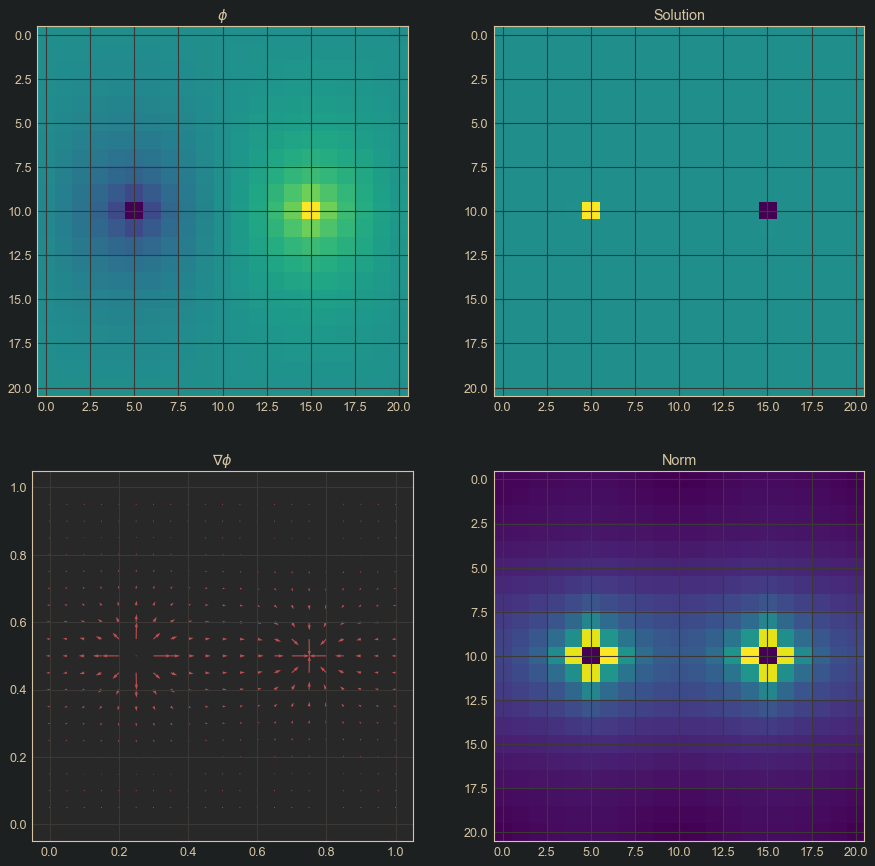

In [57]:
# Optimization Problem
phi = cp.Variable(n*m)
prob = cp.Problem(cp.Minimize(cp.sum_squares(P@phi+f)))
prob.solve()
Gphi = G@phi.value
phi = phi.value.reshape(n,m)
sol = P@phi.flatten()

norm = np.array([np.linalg.norm(gphi) for gphi in Gphi.T])

plt.figure(figsize=(15,15))
plt.subplot(221)
plt.imshow(phi)
plt.title('$\phi$')
plt.subplot(222)
plt.title('Solution')
plt.imshow(sol.reshape(n,m))
plt.subplot(223)
plt.title('$\\nabla\phi$')
plt.quiver(xx,yy,Gphi[0],Gphi[1], color='r', scale = n//5)
plt.subplot(224)
plt.title('Norm')
plt.imshow(norm.reshape(n,m))

# Variable Coefficient Elliptic Solver

## Arithmetic Averaging

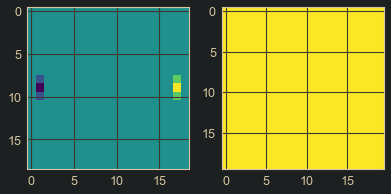

In [58]:
n = m = 21
h=1/(n-1)
xx,yy = np.meshgrid(np.linspace(0,1,n),np.linspace(0,1,m))

BC = "Neumann"

# Initial Distribution
rho = np.zeros((n,m))
rho[m//2,n//10] = 1
rho[m//2-1,n//10] = .5
rho[m//2+1,n//10] = .5

# Final Distribution
sigma = np.zeros((n,m))
sigma[m // 2,9*n // 10] = 1
sigma[m // 2-1,9*n // 10] = .5
sigma[m // 2+1,9*n // 10] = .5

f = (sigma[1:-1,1:-1]-rho[1:-1,1:-1]).flatten()

#lambda
# mid_section = [1]*(8*n//10)+[0]*(2*n//10)
# lam = np.array([0]*((m//2)*(n-5) + n//10)+mid_section*4+[1e-8]*((m//2)*(n-5)-2)).reshape(n-1,m-1)
lam = np.ones((n-1,m-1))


plt.subplot(121)
plt.imshow(f.reshape((n-2,m-2)))
plt.subplot(122)
plt.imshow(lam.reshape(n-1,m-1), vmin=0, vmax=1)

In [59]:
A = VP2A(n-1,m-1,lam.flatten())
Dx = D2xFE(n,m, BC,matrix=True)
Dy = D2yFE(n,m, BC,matrix=True)
Grad = np.vstack([Dx,Dy])

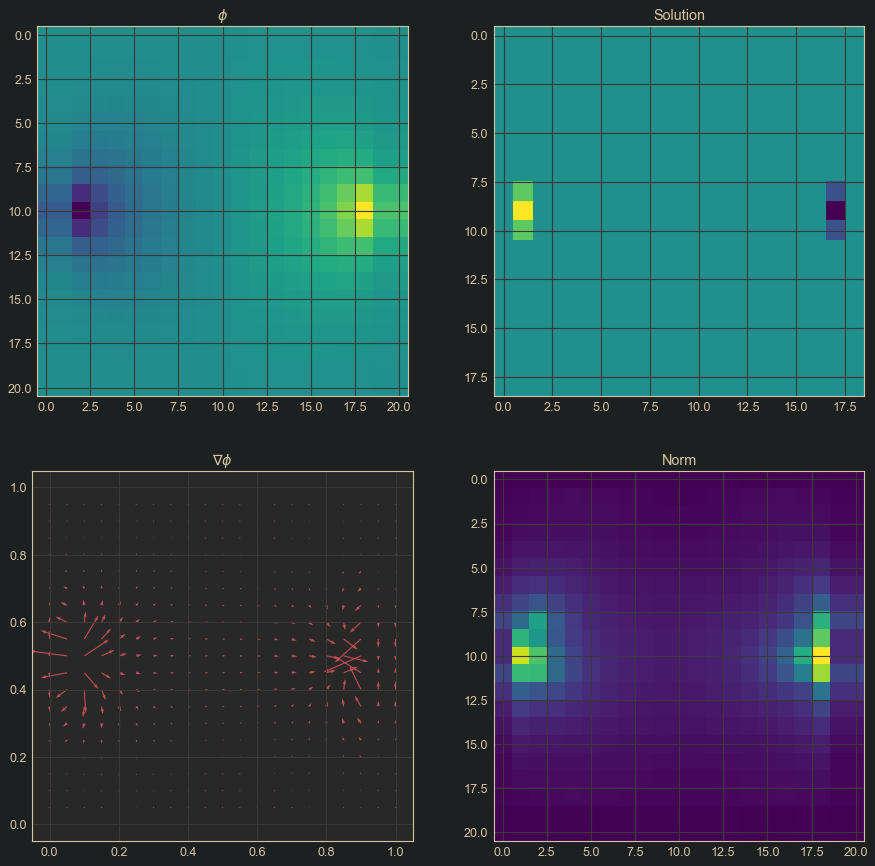

In [60]:
phi = cp.Variable((n-2)*(m-2))
prob = cp.Problem(cp.Minimize(cp.sum_squares(A@phi+f.flatten())))
prob.solve()
phi = phi.value.reshape(n-2,m-2)
sol = A@phi.flatten()

#Extend PHI
phi = np.vstack((phi[0,:],phi,phi[-1,:]))
phi = np.vstack((phi[:,0], phi.T, phi[:,-1])).T


Gphi = (Grad@phi.flatten()).reshape(2,n*m)
norm = np.array([np.linalg.norm(gphi) for gphi in Gphi.T])

plt.figure(figsize=(15,15))
plt.subplot(221)
plt.imshow(phi)
plt.title('$\phi$')
plt.subplot(222)
plt.title('Solution')
plt.imshow(sol.reshape(n-2,m-2))
plt.subplot(223)
plt.title('$\\nabla\phi$')
plt.quiver(xx,yy,Gphi[0],Gphi[1], color='r', scale = n//5)
plt.subplot(224)
plt.title('Norm')
plt.imshow(norm.reshape(n,m))

## Harmonic Averaging

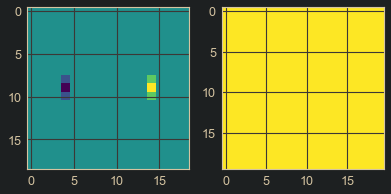

In [61]:
n = m = 21
h=1/(n-1)
xx,yy = np.meshgrid(np.linspace(0,1,n),np.linspace(0,1,m))

BC = "Neumann"

# Initial Distribution
rho = np.zeros((n,m))
rho[m//2,n//4] = 1
rho[m//2-1,n//4] = .5
rho[m//2+1,n//4] = .5

# Final Distribution
sigma = np.zeros((n,m))
sigma[m // 2,3*n // 4] = 1
sigma[m // 2-1,3*n // 4] = .5
sigma[m // 2+1,3*n // 4] = .5

f = (sigma[1:-1,1:-1]-rho[1:-1,1:-1]).flatten()

#lambda
# mid_section = [1]*(8*n//10)+[0]*(2*n//10)
# lam = np.array([0]*((m//2)*(n-5) + n//10)+mid_section*4+[1e-3]*((m//2)*(n-5)-2)).reshape(n-1,m-1)
lam = np.ones((n-1,m-1))


plt.subplot(121)
plt.imshow(f.reshape((n-2,m-2)))
plt.subplot(122)
plt.imshow(lam.reshape(n-1,m-1), vmin=0, vmax=1)

In [62]:
H = VP2H(n-1,m-1,lam.flatten())
Dx = D2xFE(n,m, BC,matrix=True)
Dy = D2yFE(n,m, BC,matrix=True)
Grad = np.vstack([Dx,Dy])

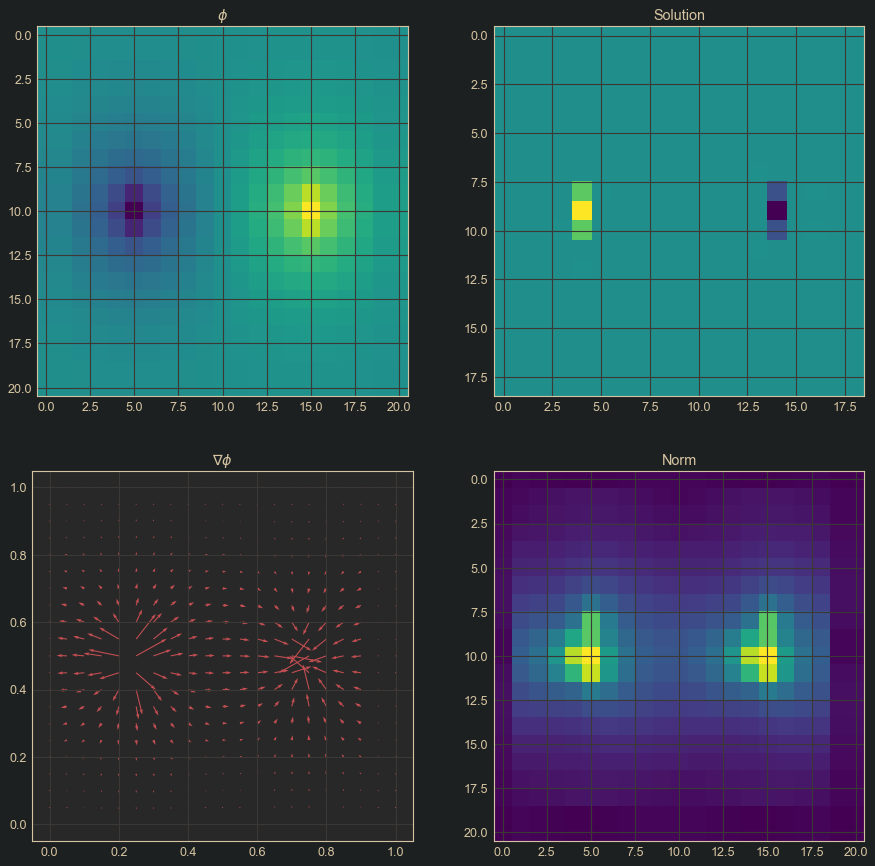

In [63]:
phi = cp.Variable((n-2)*(m-2))
prob = cp.Problem(cp.Minimize(cp.sum_squares(H@phi+f.flatten())))
prob.solve()
phi = phi.value.reshape(n-2,m-2)
sol = H@phi.flatten()

#Extend PHI
phi = np.vstack((phi[0,:],phi,phi[-1,:]))
phi = np.vstack((phi[:,0], phi.T, phi[:,-1])).T


Gphi = (Grad@phi.flatten()).reshape(2,n*m)
norm = np.array([np.linalg.norm(gphi) for gphi in Gphi.T])

plt.figure(figsize=(15,15))
plt.subplot(221)
plt.imshow(phi)
plt.title('$\phi$')
plt.subplot(222)
plt.title('Solution')
plt.imshow(sol.reshape(n-2,m-2))
plt.subplot(223)
plt.title('$\\nabla\phi$')
plt.quiver(xx,yy,Gphi[0],Gphi[1], color='r', scale = n//5)
plt.subplot(224)
plt.title('Norm')
plt.imshow(norm.reshape(n,m))

# Solution Comparison

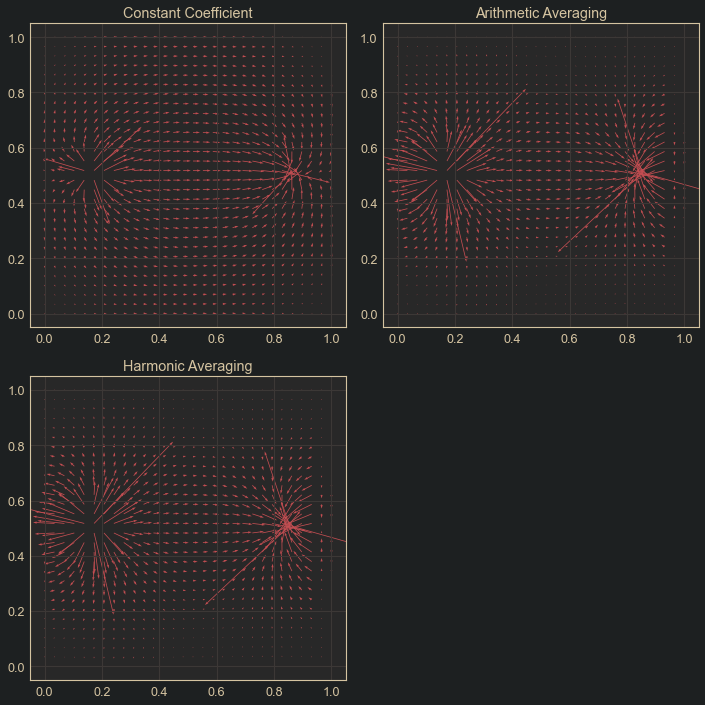

In [64]:
itrs = 10
BC = "Neumann"

# GENERATE GRID
n = m = 5*6
h=1/(n-1)
xx,yy = np.meshgrid(np.linspace(0,1,n),np.linspace(0,1,n))

# GENERATE DISTRIBUTIONS
rho = np.zeros((n,n))
rho[m//2,n//6] = 1
sigma = np.zeros((n,n))
sigma[m // 2,5*n // 6] = 1
f1 = sigma.flatten()-rho.flatten()
f2 = (sigma[1:-1,1:-1]-rho[1:-1,1:-1]).flatten()

# GENERATE KAPPA VARIABLES
lam = np.ones((n-1)*(m-1))
Gc = np.ones(m*n)

# GENERATE FDMs
Dx = D2xFE(n,m, BC,matrix=True)
Dy = D2yFE(n,m, BC,matrix=True)
Grad = np.array([Dx,Dy])/h
P = DD2P5(n,m,bc=BC,matrix=True)
A= VP2A(n-1,m-1,lam.flatten())
H= VP2A(n-1,m-1,lam.flatten())

phi1 = cp.Variable(n*m)
prob = cp.Problem(cp.Minimize(cp.sum_squares(P@phi1+f1)))
prob.solve()
Gphi1 = Grad@phi1.value


phi2 = cp.Variable((n-2)*(m-2))
prob = cp.Problem(cp.Minimize(cp.sum_squares(A@phi2+f2)))
prob.solve()
#EXTEND PHI
phi = phi2.value.reshape((n-2,m-2))
phi = np.vstack((phi[0,:],phi,phi[-1,:]))
phi = np.vstack((phi[:,0], phi.T, phi[:,-1])).T
Gphi2 = Grad@phi.flatten()

phi3 = cp.Variable((n-2)*(m-2))
prob = cp.Problem(cp.Minimize(cp.sum_squares(H@phi3+f2)))
prob.solve()
#EXTEND PHI
phi = phi3.value.reshape((n-2,m-2))
phi = np.vstack((phi[0,:],phi,phi[-1,:]))
phi = np.vstack((phi[:,0], phi.T, phi[:,-1])).T
Gphi3 = Grad@phi.flatten()

plt.figure(figsize=(10,10), tight_layout=True)
plt.subplot(221)
plt.title('Constant Coefficient')
plt.quiver(xx,yy,Gphi1[0],Gphi1[1],color='r')
plt.subplot(222)
plt.title('Arithmetic Averaging')
plt.quiver(xx,yy,Gphi2[0],Gphi2[1],color='r')
plt.subplot(223)
plt.title('Harmonic Averaging')
plt.quiver(xx,yy,Gphi3[0],Gphi3[1],color='r')